# voxTrace Interface

To create an environment use:

        conda create --name vt python=3 xraylib=4.1.3 jupyter ipykernel matplotlib h5py pandas -c conda-forge

        conda activate vt

## UI

In [1]:
import os
import numpy as np
import h5py as h5p
import xraylib as xrl
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import re
import colorsys

current_path = os.getcwd()

### Create Sample

In [2]:
# Define sample size and voxel size
sample_size = np.array([300., 300., 150.]) # in units of micrometers
voxel_size = np.array([1.0, 1.0, 1.0]) # in units of micrometers

# Calculate number of voxels in each dimension
num_voxels = np.ceil(sample_size / voxel_size).astype(int)

In [3]:
# Define materials NIST_1107
materials = [
    {
        "z_range": (0, 300),
        "elements": [26, 28, 29, 30, 50, 82],
        "mass_fractions": [0.0004, 0.0010, 0.6119, 0.3741, 0.0107, 0.0019]
    }
]

# path to test-data measurement file
path_start = current_path + "/test-data/simulation"

In [101]:
for material in materials:
    print(material)

{'z_range': (0, 300), 'elements': [26, 28, 29, 30, 50, 82], 'mass_fractions': [0.0004, 0.001, 0.6119, 0.3741, 0.0107, 0.0019]}


In [13]:
# Define materials Triple-Cross
materials = [
    {
        "z_range": (0, 50),
        "elements": [6,24],
        "mass_fractions": [0.999651886257307,0.00034811374269286]
    },
    {
        "z_range": (50, 100),
        "elements": [6,27],
        "mass_fractions": [0.999543658490524,0.000456341509475796]
    },
    {
        "z_range": (100, 150),
        "elements": [6,30],
        "mass_fractions": [0.999378760356556,0.000621239643443875]
    },
    {
        "z_range": (150, 200),
        "elements": [6],
        "mass_fractions": [1.0]
    }
]

# path to test-data measurement file
path_start = current_path + "/test-data/simulation/triple-cross"

In [ ]:
# Write output to text file
with open(path_start+"/Materials.txt", "w") as f:
    # Write header
    f.write("# Materials\n")
    for i in range(np.prod(num_voxels)):
        # Write point information
        x, y, z = np.unravel_index(i, num_voxels)
        for material in materials:
            if material["z_range"][0]/voxel_size[2] <= z < material["z_range"][1]/voxel_size[2]:
                f.write("# Point {}\n".format(i+1))
                f.write("{}, {}, {} \t\t\t\t\t\t\t\t\t\t # x,y,z \n".format(x, y, z))
                f.write("{} \t\t\t\t\t\t\t\t\t\t\t\t # Number of Elements\n".format(len(material["elements"]))) # number of elements
                f.write("{} \t\t\t\t\t\t\t # Elements Z\n".format(", ".join(map(str, material["elements"])))) # elements Z
                f.write("{} \t # Element Mass Fractions\n \n".format(", ".join(map(str, material["mass_fractions"])))) # elements mass fraction
                break

In [107]:
# Write output to text file
with open(path_start+"/Materials.txt", "w") as f:
    # Write header
    f.write("# Materials\n")
    for i in range(np.prod(num_voxels)):
        # Write point information
        x, y, z = np.unravel_index(i, num_voxels)
        for material in materials:
            if material["z_range"][0]/voxel_size[2] <= z < material["z_range"][1]/voxel_size[2]:
                if x % 2 == 0 and y % 2 == 0:
                    material = {'elements': [8], 'mass_fractions': [1.0]}  # Assign a different material for even x, even y, and z = 0
                else:
                    material = material # Assign the default material for other points
                f.write("# Point {}\n".format(i+1))
                f.write("{}, {}, {} \t\t\t\t\t\t\t\t\t\t # x,y,z \n".format(x, y, z))
                f.write("{} \t\t\t\t\t\t\t\t\t\t\t\t # Number of Elements\n".format(len(material["elements"]))) # number of elements
                f.write("{} \t\t\t\t\t\t\t # Elements Z\n".format(", ".join(map(str, material["elements"])))) # elements Z
                f.write("{} \t # Element Mass Fractions\n \n".format(", ".join(map(str, material["mass_fractions"])))) # elements mass fraction
                break

## Evaluation: Measurement Data vs. Simulation

#### NIST-1107

In [2]:
# path to test-data measurement file
file_loc_1  = current_path + "/test-data/measurement/nist-1107/nist-1107-depth-00-00.txt"
file_loc_2  = current_path + "/test-data/measurement/nist-1107/nist-1107-depth-00-01.txt"
file_loc_3  = current_path + "/test-data/measurement/nist-1107/nist-1107-depth-01-00.txt"

# Read the file into a pandas dataframe
df_1 = pd.read_csv(file_loc_1, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])
df_2 = pd.read_csv(file_loc_2, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])
df_3 = pd.read_csv(file_loc_3, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])

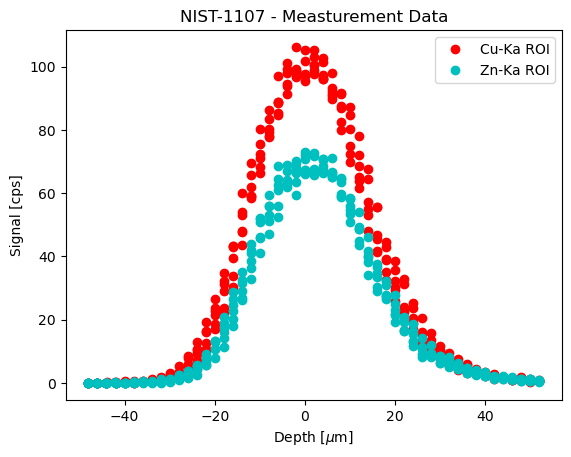

In [3]:
# find position of maximum signal df_3["px5.Cu-Ka-Gro[708,755]"]
max_pos = df_3["px5.Cu-Ka-Gro[708,755]"].idxmax()
max_corr= df_3["Motor-samplex"][max_pos]+2

# Plot the data
plt.ylabel("Signal [cps]")
plt.xlabel("Depth [$\mu$m]")
plt.plot(df_3["Motor-samplex"]-max_corr,df_3["px5.Cu-Ka-Gro[708,755]"]/df_3["px5.Livetime"],'ro',label='Cu-Ka ROI')
plt.plot(df_3["Motor-samplex"]-max_corr,df_3["px5.Zn-Ka-Gro[770,800]"]/df_3["px5.Livetime"],'co',label='Zn-Ka ROI')
#plt.plot(myrange1, cu_faltung,'y',label='Cu-Ka')
#plt.plot(myrange1, zn_faltung,'g',label='Zn-Ka')
plt.legend()
plt.title('NIST-1107 - Measturement Data')
plt.show()

In [8]:
# list all files in directory
directory = current_path + "/test-data/simulation/nist-1107-new-tilt-5deg/post-sample/"
directory_2 = current_path + "/test-data/simulation/nist-1107-new-tilt-5deg/detector"

files = os.listdir(directory)
files_2 = os.listdir(directory_2)

files = sorted(files, key=lambda x: float(x.split('--z-')[1].split(').h5')[0]))
files_2 = sorted(files_2, key=lambda x: float(x.split('--z-')[1].split(').h5')[0]))

files = [os.path.join(directory, file) for file in files]
files_2 = [os.path.join(directory_2, file) for file in files_2]

n_files = len(files)

energies = []
respawns = []
respawns_sum = []

energies_2 = []
probs_2 = []
probs_2_sum = []

for i in range(n_files):
    energies.append(h5p.File(files[i], 'r')['my_data'][10] / 50677300.0)
    respawns.append(h5p.File(files[i], 'r')['my_data'][20])
    respawns_sum.append(h5p.File(files[i], 'r')['my_data'][20].sum())

    energies_2.append(h5p.File(files_2[i], 'r')['my_data'][10] / 50677300.0)
    probs_2.append(h5p.File(files_2[i], 'r')['my_data'][18])
    probs_2_sum.append(h5p.File(files_2[i], 'r')['my_data'][18].sum())

energies_respawns = []
energies_probs = []

for i in range(n_files):
    energies_respawns.append(np.array([energies[i], respawns[i]]).transpose())
    energies_probs.append(np.array([energies_2[i], probs_2[i]]).transpose())

# Define the number of bins and the range of energies
my_bins = 2048
my_range = (-0.1718, 22.6634)

# Create the bin edges
bin_edges = np.linspace(start=my_range[0], stop=my_range[1], num=my_bins+1)


In [9]:
post_sample_energy_hists = []
post_sample_respawn_hists = []

detector_energy_hists = []
detector_prob_hists = []

for i in range(n_files):
    energy_respawn = energies_respawns[i]
    energy, respawn = zip(*energy_respawn)

    histograms_1 = np.zeros(my_bins)
    histograms_2 = np.zeros(my_bins)

    post_sample_energy_hists.append(np.zeros(my_bins))
    post_sample_respawn_hists.append(np.zeros(my_bins))

    detector_energy_hists.append(np.zeros(my_bins))
    detector_prob_hists.append(np.zeros(my_bins))

    for energy, respawn in energy_respawn:
        bin_index = np.digitize([energy], bin_edges)[0] - 1
        post_sample_energy_hists[i][bin_index] += 1
        post_sample_respawn_hists[i][bin_index] += respawn

    en_prob = energies_probs[i]
    en, prob = zip(*en_prob)

    for en, prob in en_prob:
        bin_index = np.digitize([en], bin_edges)[0] - 1
        detector_energy_hists[i][bin_index] += 1
        detector_prob_hists[i][bin_index] += prob

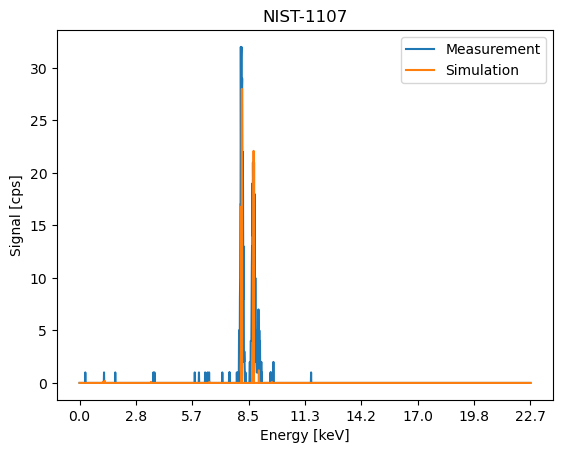

In [7]:
#print(files_2[7])
sim_spec = detector_energy_hists[7].tolist()
scale_sim = 0.1
sim_spec = [x * scale_sim for x in sim_spec]

# Plot the data
file_name= current_path + "/test-data/measurement/nist-1107/000034.spe"
numbers = []
# open file_name skip 7 lines then read tab separated numbers to list
with open(file_name) as f:
    for i in range(8):
        next(f)
    for line in f:
        numbers.append([float(x) for x in line.split()])

##flatten numbers array
numbers = [item for sublist in numbers for item in sublist]
meas_spec = numbers[0:2048]
scale_meas = 1
meas_spec = [x * scale_meas for x in meas_spec]

# Plot the bar chart
plt.plot(meas_spec, label='Measurement')
plt.plot(sim_spec, label='Simulation')
plt.ylabel("Signal [cps]")
plt.xlabel("Energy [keV]")

# make ticks and tick labels
ticks = [0, 256, 511, 767, 1023, 1279, 1535, 1791, 2047]
#tick label is tick /2048 * 22.6634
tick_labels = [round(x / 2048 * 22.6634, 1) for x in ticks]
#rename xticks individually
plt.xticks(ticks,tick_labels)
plt.legend()
plt.title('NIST-1107')
plt.show()

In [14]:
histogramm_list = []
cu = []
zn = []
tot = []

cu_2 = []
zn_2 = []
tot_2 = []

cu_respawn = []
zn_respawn = []
tot_respawn = []

cu_prob = []
zn_prob = []
tot_prob = []

cu_faltung = []
zn_faltung = []
tot_faltung = []

ps_ratio = []

for i in range(0, n_files):
    # Make a HistogrammList of energies[1] with 2048 bins and a bin width of 0.01115 and an offset of -0.1718 and store it as array
    #histogramm = np.histogram(energies_2[i], bins=2048, range=(-0.1718, 22.6634))
    #histogramm_list.append(histogramm)

    # make sum of channels [708,755] and [756,803] and store it as array
    cu.append(np.sum(post_sample_energy_hists[i][708:755])) #/respawns[i] *6000000.
    zn.append(np.sum(post_sample_energy_hists[i][756:803])) #/respawns[i] *6000000.
    tot.append(np.sum(post_sample_energy_hists[i][0:2048])) #/respawns[i]
    #zn.append(np.sum(histogramm[0][756:803])/respawns_sum[i]) #/respawns[i] *6000000.
    #tot.append(np.sum(histogramm[0][0:2048])/respawns_sum[i]) #/respawns[i]

    cu_respawn.append(np.sum(post_sample_respawn_hists[i][708:755]))
    zn_respawn.append(np.sum(post_sample_respawn_hists[i][756:803]))
    tot_respawn.append(np.sum(post_sample_respawn_hists[i][0:2048]))

    cu_prob.append(np.sum(detector_prob_hists[i][708:755]))#/np.sum(detector_energy_hists[i][708:755])
    zn_prob.append(np.sum(detector_prob_hists[i][756:803]))#/np.sum(detector_energy_hists[i][756:803])
    tot_prob.append(np.sum(detector_prob_hists[i][0:2048]))#/np.sum(detector_energy_hists[i][0:2048])

    cu_faltung.append(np.sum(detector_energy_hists[i][708:755])/np.sum(post_sample_respawn_hists[i][0:2048])*30000000.)
    zn_faltung.append(np.sum(detector_energy_hists[i][756:803])/np.sum(post_sample_respawn_hists[i][0:2048])*30000000.)
    tot_faltung.append(np.sum(detector_energy_hists[i][0:2048])/np.sum(post_sample_respawn_hists[i][0:2048]))

    cu_2.append(np.sum(detector_energy_hists[i][708:755]))#*np.exp(-(i-20)*0.1)*10e6
    zn_2.append(np.sum(detector_energy_hists[i][756:803]))
    tot_2.append(np.sum(detector_energy_hists[i][0:2048]))
    
    ps_ratio.append(cu_2[i]/cu[i])

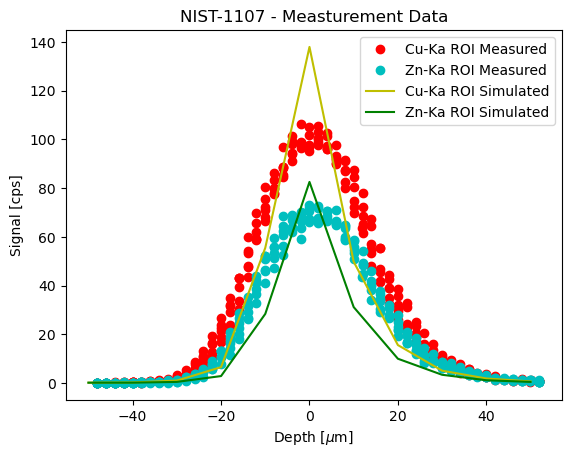

In [15]:
# create list with int entries from 0 to n_files-1 
myrange1 = [i*10-50 for i in range(n_files)]

# find position of maximum signal df_3["px5.Cu-Ka-Gro[708,755]"]
max_pos = df_3["px5.Cu-Ka-Gro[708,755]"].idxmax()
max_corr= df_3["Motor-samplex"][max_pos]+2

# Plot the data
plt.ylabel("Signal [cps]")
plt.xlabel("Depth [$\mu$m]")
plt.plot(df_3["Motor-samplex"]-max_corr,df_3["px5.Cu-Ka-Gro[708,755]"]/df_3["px5.Livetime"],'ro',label='Cu-Ka ROI Measured')
plt.plot(df_3["Motor-samplex"]-max_corr,df_3["px5.Zn-Ka-Gro[770,800]"]/df_3["px5.Livetime"],'co',label='Zn-Ka ROI Measured')
plt.plot(myrange1, cu_faltung,'y',label='Cu-Ka ROI Simulated')
plt.plot(myrange1, zn_faltung,'g',label='Zn-Ka ROI Simulated')
plt.legend()
plt.title('NIST-1107 - Measturement Data')
plt.show()

In [16]:
# new list with each element of cu_faltung divided by the corresponding element of zn_faltung
mylist = [x/y for x, y in zip(cu_faltung, zn_faltung)]
myList2 = df_3["px5.Cu-Ka-Gro[708,755]"].tolist() 
mylist3= df_3["px5.Zn-Ka-Gro[770,800]"].tolist()

#divide each element of mylist2 by the corresponding element of mylist3
mylist4 = [x / (y+1) for x, y in zip(myList2, mylist3)]

Text(0.5, 1.0, 'NIST-1107')

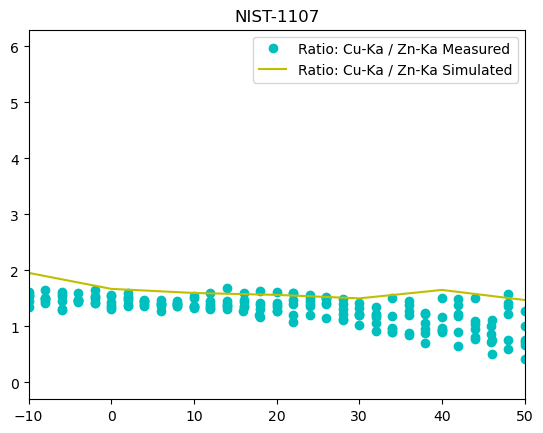

In [17]:
plt.plot(df_3["Motor-samplex"]-max_corr,mylist4,'co',label='Ratio: Cu-Ka / Zn-Ka Measured')
plt.plot(myrange1, mylist,'y',label='Ratio: Cu-Ka / Zn-Ka Simulated')
# change plot range
plt.xlim(-10, 50)
plt.legend()
plt.title('NIST-1107')

#### Triple-Cross-Structure

In [28]:
file_loc_4 = current_path + '/test-data/measurement/triple-cross/Cr-Co-Zn-Kreuze-auf-pure-v15-depth-02.txt'

# Read the file into a pandas dataframe
df_4 = pd.read_csv(file_loc_4, sep='\t', skiprows=8, header=None, names=["Motor-samplexraw","Motor-sampleyraw","Motor-samplex","Motor-sampley","Motor-samplez","Motor-cap1x","Motor-cap1y","Motor-cap1z","Motor-cap1yaw","Motor-cap1pitch","Motor-detectorx","Motor-detectory","Motor-detectorz","Motor-mic","px5.Gd-La-Gro[525,566]","px5.Gd-La-Net[525,566]","px5.Cu-Ka-Gro[673,763]","px5.Cu-Ka-Net[673,763]","px5.Cu-Kb-Gro[799,846]","px5.Cu-Kb-Net[799,846]","px5.Fe-Ka-Gro[560,613]","px5.Fe-Ka-Net[560,613]","px5.Fe-Kb-Gro[615,671]","px5.Fe-Kb-Net[615,671]","px5.Cr-Ka-Gro[459,521]","px5.Cr-Ka-Net[459,521]","px5.Cr-Kb-Gro[519,560]","px5.Cr-Kb-Net[519,560]","px5.Zn-Ka-Gro[763,799]","px5.Zn-Ka-Net[763,799]","px5.Zn-Kb-Gro[840,908]","px5.Zn-Kb-Net[840,908]","px5.Sn-L-Gro[292,402]","px5.Sn-L-Net[292,402]","px5.Co-Ka-Gro[600,656]","px5.Co-Ka-Net[600,656]","px5.Realtime","px5.Livetime","px5.Deadtime","px5.icr","px5.ocr","tube.Voltage","tube.Current","px5.Filename"])

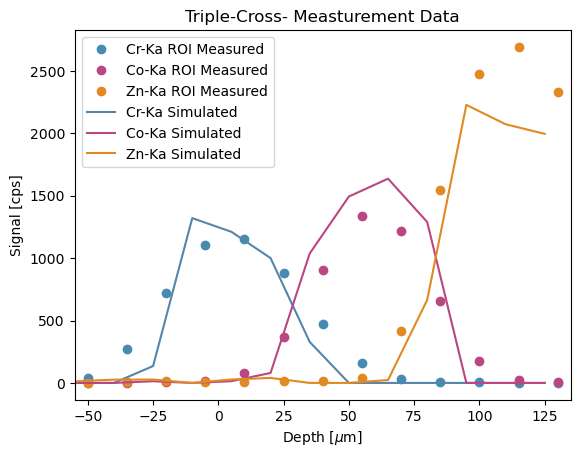

In [96]:
# create list with int entries from 0 to n_files-1 
myrange1 = [i*15-45-10 for i in range(n_files)]

# find position of maximum signal df_3["px5.Cu-Ka-Gro[708,755]"]
max_pos = df_4["px5.Cr-Ka-Gro[459,521]"].idxmax()
max_corr= df_4["Motor-samplex"][max_pos]-10

# Plot the data
plt.ylabel("Signal [cps]")
plt.xlabel("Depth [$\mu$m]")
plt.plot(df_4["Motor-samplex"]-max_corr,df_4["px5.Cr-Ka-Gro[459,521]"]/df_4["px5.Livetime"],'#478BB3', marker='o',linestyle='',label='Cr-Ka ROI Measured')
plt.plot(df_4["Motor-samplex"]-max_corr,df_4["px5.Co-Ka-Gro[600,656]"]/df_4["px5.Livetime"],color='#BA4682', marker='o',linestyle='',label='Co-Ka ROI Measured')
plt.plot(df_4["Motor-samplex"]-max_corr,df_4["px5.Zn-Ka-Gro[763,799]"]/df_4["px5.Livetime"],color='#E18922', marker='o',linestyle='',label='Zn-Ka ROI Measured')
plt.plot(myrange1, cr_faltung,color='#5485AB',label='Cr-Ka Simulated')
plt.plot(myrange1, co_faltung,color='#BA4682',label='Co-Ka Simulated')
plt.plot(myrange1, zn_faltung,color='#E18922',label='Zn-Ka Simulated')
#xrange
plt.xlim(-55, 135)
plt.legend()
plt.title('Triple-Cross- Measturement Data')
plt.show()

In [30]:
# list all files in directory
directory = current_path + '/test-data/simulation/triple-cross/post-sample'
directory_2 =  current_path + '/test-data/simulation/triple-cross/detector'

files = os.listdir(directory)
files_2 = os.listdir(directory_2)

files = sorted(files, key=lambda x: float(x.split('--z-')[1].split(').h5')[0]))
files_2 = sorted(files_2, key=lambda x: float(x.split('--z-')[1].split(').h5')[0]))

files = [os.path.join(directory, file) for file in files]
files_2 = [os.path.join(directory_2, file) for file in files_2]

In [32]:
n_files = len(files)

energies = []
respawns = []
respawns_sum = []

energies_2 = []
probs_2 = []
probs_2_sum = []

for i in range(n_files):
    energies.append(h5p.File(files[i], 'r')['my_data'][10] / 50677300.0)
    respawns.append(h5p.File(files[i], 'r')['my_data'][20])
    respawns_sum.append(h5p.File(files[i], 'r')['my_data'][20].sum())

    energies_2.append(h5p.File(files_2[i], 'r')['my_data'][10] / 50677300.0)
    probs_2.append(h5p.File(files_2[i], 'r')['my_data'][18])
    probs_2_sum.append(h5p.File(files_2[i], 'r')['my_data'][18].sum())

energies_respawns = []
energies_probs = []

for i in range(n_files):
    energies_respawns.append(np.array([energies[i], respawns[i]]).transpose())
    energies_probs.append(np.array([energies_2[i], probs_2[i]]).transpose())

In [34]:
# Define the number of bins and the range of energies
my_bins = 2048
my_range = (-0.1718, 22.6634)

# Create the bin edges
bin_edges = np.linspace(start=my_range[0], stop=my_range[1], num=my_bins+1)

post_sample_energy_hists = []
post_sample_respawn_hists = []

detector_energy_hists = []
detector_prob_hists = []

for i in range(n_files):
    energy_respawn = energies_respawns[i]
    energy, respawn = zip(*energy_respawn)

    histograms_1 = np.zeros(my_bins)
    histograms_2 = np.zeros(my_bins)

    post_sample_energy_hists.append(np.zeros(my_bins))
    post_sample_respawn_hists.append(np.zeros(my_bins))

    detector_energy_hists.append(np.zeros(my_bins))
    detector_prob_hists.append(np.zeros(my_bins))

    for energy, respawn in energy_respawn:
        bin_index = np.digitize([energy], bin_edges)[0] - 1
        post_sample_energy_hists[i][bin_index] += 1
        post_sample_respawn_hists[i][bin_index] += respawn

    en_prob = energies_probs[i]
    en, prob = zip(*en_prob)

    for en, prob in en_prob:
        bin_index = np.digitize([en], bin_edges)[0] - 1
        detector_energy_hists[i][bin_index] += 1
        detector_prob_hists[i][bin_index] += prob

In [35]:
histogramm_list = []
cr = []
co = []
zn = []
tot = []

cr_2 = []
co_2 = []
zn_2 = []
tot_2 = []

cr_respawn = []
co_respawn = []
zn_respawn = []
tot_respawn = []

cr_prob = []
co_prob = []
zn_prob = []
tot_prob = []

cr_faltung = []
co_faltung = []
zn_faltung = []
tot_faltung = []

for i in range(0, n_files):
    cr.append(np.sum(post_sample_energy_hists[i][459:521]))
    co.append(np.sum(post_sample_energy_hists[i][600:656]))
    zn.append(np.sum(post_sample_energy_hists[i][763:799]))
    tot.append(np.sum(post_sample_energy_hists[i][0:2048])) 

    cr_respawn.append(np.sum(post_sample_respawn_hists[i][459:521]))
    co_respawn.append(np.sum(post_sample_respawn_hists[i][600:656]))
    zn_respawn.append(np.sum(post_sample_respawn_hists[i][763:799]))
    tot_respawn.append(np.sum(post_sample_respawn_hists[i][0:2048]))

    cr_prob.append(np.sum(detector_prob_hists[i][459:521]))
    co_prob.append(np.sum(detector_prob_hists[i][600:656]))
    zn_prob.append(np.sum(detector_prob_hists[i][763:799]))
    tot_prob.append(np.sum(detector_prob_hists[i][0:2048]))

    cr_faltung.append(np.sum(detector_energy_hists[i][459:521])/np.sum(post_sample_respawn_hists[i][0:2048])*500000000000.)
    co_faltung.append(np.sum(detector_energy_hists[i][600:656])/np.sum(post_sample_respawn_hists[i][0:2048])*500000000000.)
    zn_faltung.append(np.sum(detector_energy_hists[i][763:799])/np.sum(post_sample_respawn_hists[i][0:2048])*500000000000.)
    tot_faltung.append(np.sum(detector_energy_hists[i][0:2048])/np.sum(post_sample_respawn_hists[i][0:2048]))

    cr_2.append(np.sum(detector_energy_hists[i][459:521]))
    co_2.append(np.sum(detector_energy_hists[i][600:656]))
    zn_2.append(np.sum(detector_energy_hists[i][763:799]))
    tot_2.append(np.sum(detector_energy_hists[i][0:2048]))

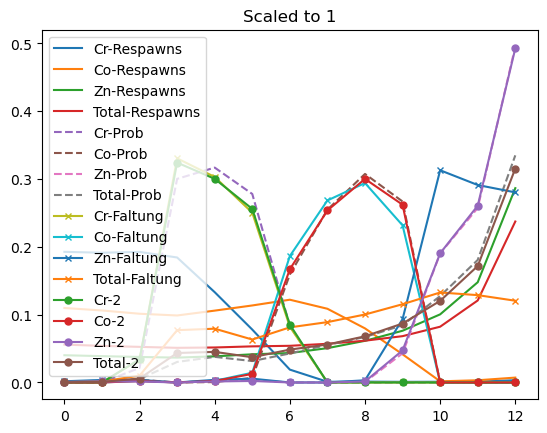

In [36]:
# plot cu_respawn and zn_respawn and tot_respawn and tot_respawn_2 scaled to 1
plt.plot(cr_respawn/np.sum(cr_respawn), label='Cr-Respawns')
plt.plot(co_respawn/np.sum(co_respawn), label='Co-Respawns')
plt.plot(zn_respawn/np.sum(zn_respawn), label='Zn-Respawns')
plt.plot(tot_respawn/np.sum(tot_respawn), label='Total-Respawns')

# plot cu_prob and zn_prob and tot_prob scaled to 1
plt.plot(cr_prob/np.sum(cr_prob), label='Cr-Prob',linestyle='--')
plt.plot(co_prob/np.sum(co_prob), label='Co-Prob',linestyle='--')
plt.plot(zn_prob/np.sum(zn_prob), label='Zn-Prob',linestyle='--')
plt.plot(tot_prob/np.sum(tot_prob), label='Total-Prob',linestyle='--')

# plot cu_faltung and zn_faltung and tot_faltung scaled to 1
plt.plot(cr_faltung/np.sum(cr_faltung), label='Cr-Faltung', marker='x', markersize=5)
plt.plot(co_faltung/np.sum(co_faltung), label='Co-Faltung', marker='x', markersize=5)
plt.plot(zn_faltung/np.sum(zn_faltung), label='Zn-Faltung', marker='x', markersize=5)
plt.plot(tot_faltung/np.sum(tot_faltung), label='Total-Faltung', marker='x', markersize=5)

# plot cu_2 and zn_2 and tot_2 scaled to 1
plt.plot(cr_2/np.sum(cr_2), label='Cr-2', marker='o', markersize=5)
plt.plot(co_2/np.sum(co_2), label='Co-2', marker='o', markersize=5)
plt.plot(zn_2/np.sum(zn_2), label='Zn-2', marker='o', markersize=5)
plt.plot(tot_2/np.sum(tot_2), label='Total-2', marker='o', markersize=5)

plt.legend()
plt.title('Scaled to 1')
plt.show()

In [41]:
# new list with each element of cu_faltung divided by the corresponding element of zn_faltung
mylist = [x/y for x, y in zip(cr_faltung, co_faltung)]
mylist2 = [x/y for x, y in zip(cr_faltung, zn_faltung)]
mylist3 = [x/y for x, y in zip(co_faltung, zn_faltung)]

mylist4= df_4["px5.Cr-Ka-Gro[459,521]"].tolist()
mylist5= df_4["px5.Co-Ka-Gro[600,656]"].tolist()
mylist6= df_4["px5.Zn-Ka-Gro[763,799]"].tolist()


#divide each element of mylist2 by the corresponding element of mylist3
mylist7 = [x / (y+1) for x, y in zip(mylist4, mylist5)]
mylist8 = [x / (y+1) for x, y in zip(mylist4, mylist6)]
mylist9 = [x / (y+1) for x, y in zip(mylist5, mylist6)]

/tmp/ipykernel_17907/3356485483.py:2: RuntimeWarning: invalid value encountered in scalar divide
  mylist = [x/y for x, y in zip(cr_faltung, co_faltung)]
/tmp/ipykernel_17907/3356485483.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  mylist = [x/y for x, y in zip(cr_faltung, co_faltung)]
/tmp/ipykernel_17907/3356485483.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  mylist2 = [x/y for x, y in zip(cr_faltung, zn_faltung)]
/tmp/ipykernel_17907/3356485483.py:3: RuntimeWarning: invalid value encountered in scalar divide
  mylist2 = [x/y for x, y in zip(cr_faltung, zn_faltung)]
/tmp/ipykernel_17907/3356485483.py:4: RuntimeWarning: invalid value encountered in scalar divide
  mylist3 = [x/y for x, y in zip(co_faltung, zn_faltung)]
/tmp/ipykernel_17907/3356485483.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mylist3 = [x/y for x, y in zip(co_faltung, zn_faltung)]


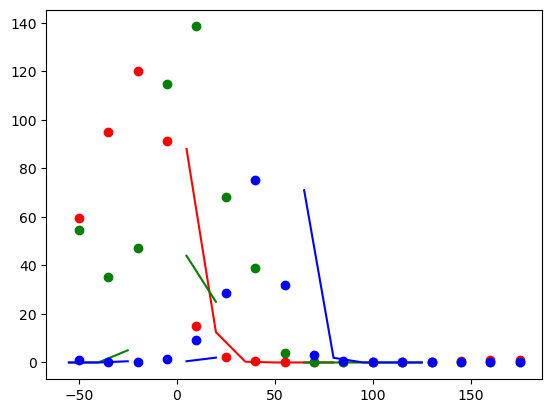

In [42]:
plt.plot(myrange1, mylist,'r',label='Cr-Ka/Co-Ka')
plt.plot(myrange1, mylist2,'g',label='Cr-Ka/Zn-Ka')
plt.plot(myrange1, mylist3,'b',label='Co-Ka/Zn-Ka')

plt.plot(df_4["Motor-samplex"]-max_corr,mylist7,'ro',label='Cr-Ka/Co-Ka')
plt.plot(df_4["Motor-samplex"]-max_corr,mylist8,'go',label='Cr-Ka/Zn-Ka')
plt.plot(df_4["Motor-samplex"]-max_corr,mylist9,'bo',label='Co-Ka/Zn-Ka')

## Work in Progress

### Triple-Cross

In [39]:
# new list with each element of cu_faltung divided by the corresponding element of zn_faltung
mylist = [x/y for x, y in zip(cu_faltung, zn_faltung)]

/tmp/ipykernel_7307/2415953662.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  mylist = [x/y for x, y in zip(cu_faltung, zn_faltung)]


In [30]:
file_loc_1 = '/media/miro/Data-1TB/nist-1107-measurement/nist-1107-depth-00-00/nist-1107-depth-00-00.txt'
file_loc_2 = '/media/miro/Data-1TB/nist-1107-measurement/nist-1107-depth-00-01/nist-1107-depth-00-01.txt'
file_loc_3 = '/media/miro/Data-1TB/nist-1107-measurement/nist-1107-depth-01-00/nist-1107-depth-01-00.txt'

# Read the file into a pandas dataframe
df_1 = pd.read_csv(file_loc_1, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])
df_2 = pd.read_csv(file_loc_2, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])
df_3 = pd.read_csv(file_loc_3, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])

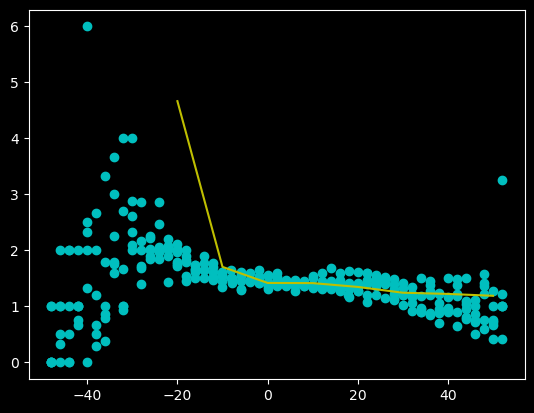

In [40]:
plt.plot(df_3["Motor-samplex"]-max_corr,mylist4,'co',label='Cu-Ka')
plt.plot(myrange1, mylist,'y',label='Cu-Ka')

#plt.plot(myrange1, zn_faltung,'g',label='Zn-Ka')

### Call the code

In [ ]:
os.popen('./build/bin/Test-3').read()